In [1]:

%matplotlib inline
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output
import numpy as np
import pandas as pd
import time

## Evolutionäre Strategie 
### angewendet auf das Traveling Salesman Problem (TSP)



In [8]:
# Parameter widgets
width = '20%'
color = 'green'
plot_size = 10

# Anzahl an Städten
n = widgets.IntSlider(value=20, min=10, max=100, step=2, description='Anzahl Städte (n):', continuous_update=False, layout=widgets.Layout(width=width), style={'description_width': 'initial', 'handle_color': color})

display(n)

IntSlider(value=20, continuous_update=False, description='Anzahl Städte (n):', layout=Layout(width='20%'), min…

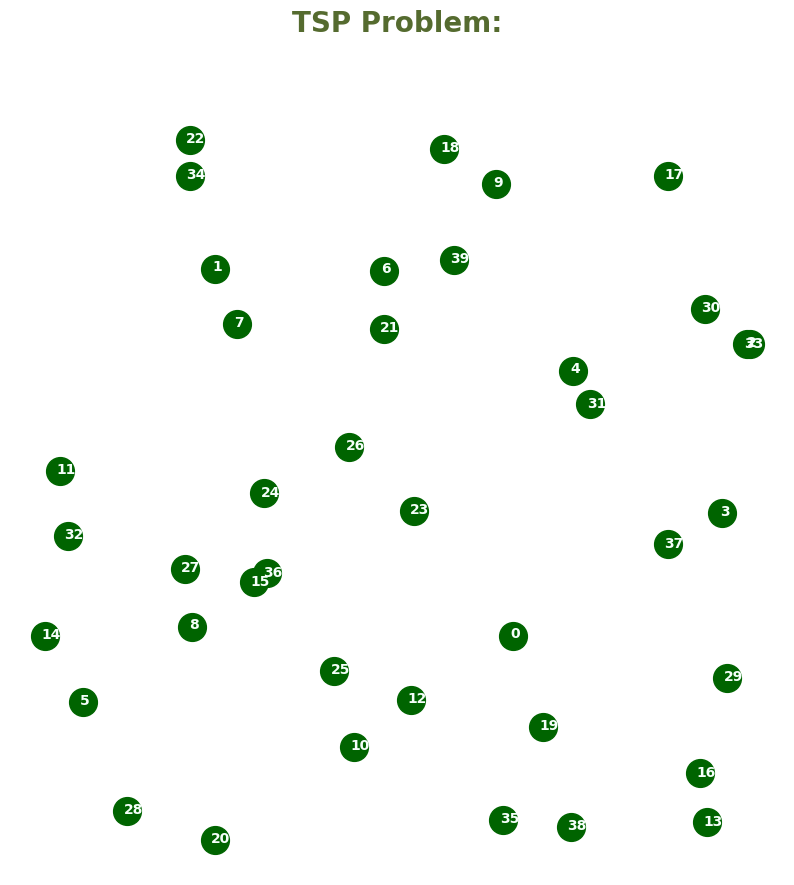

In [9]:
# Initialisierung des TSP Problems

# Festlegung der Dimensionen
m = n.value * 8

# Wuerfeln der Standorte (Koordinaten)
x = np.random.randint(1, m+1, n.value)
y = np.random.randint(1, m+1, n.value)
Init_Koord = np.column_stack((x, y))


# Plot der Standorte
plt.figure(figsize=(plot_size, plot_size))
plt.plot(Init_Koord[:, 0], Init_Koord[:, 1], 'o', color='darkgreen', markersize=20)
plt.title('TSP Problem:\n\n', fontsize=20, color='darkolivegreen', fontweight='bold') 

for i in range(n.value):
    if i >= 10:
        plt.text(x[i]-plot_size/7, y[i]-plot_size/7, str(i), color='mintcream', fontsize=10, fontweight='bold')
    else:
        plt.text(x[i]-plot_size/10, y[i]-plot_size/10, str(i), color='mintcream', fontsize=10, fontweight='bold')
plt.axis('off')
clear_output(wait = True)

# Save the initial problem for the optimization with pandas
df = pd.DataFrame(Init_Koord, columns=['x', 'y'])
df['n'] = n.value
df['m'] = m
df.to_csv('TSP_Initial_Problem.csv', index=False)

In [4]:
# Anzahl an Generationen
Σ = widgets.IntSlider(value=500, min=100, max=5000, step=100, description='Max Gen (Σ):', continuous_update=False, layout=widgets.Layout(width=width), style={'description_width': 'initial', 'handle_color': color})

# Anzahl an erlaubten Generationen ohne Verbesserung
χ = widgets.IntSlider(value=15, min=5, max=100, step=5, description='Abbruch ab (χ):', continuous_update=False, layout=widgets.Layout(width=width), style={'description_width': 'initial', 'handle_color': color})

# Populationsgroesse
μ = widgets.IntSlider(value=250, min=50, max=1000, step=50, description='Populationsgröße: (μ)', continuous_update=False, layout=widgets.Layout(width=width), style={'description_width': 'initial', 'handle_color': color})

# Anzahl der Nachkommen
λ = widgets.IntSlider(value=7, min=1, max=10, step=1, description='Nachkommen pro Elter: (λ)', continuous_update=False, layout=widgets.Layout(width=width), style={'description_width': 'initial', 'handle_color': color})

# Wahrscheinlichkeit für eine Zwei-Kanten-Mutation
α = widgets.FloatSlider(value=0.5, min=0.0, max=1.0, step=0.05, description='Zwei-Kanten-Mutation: (α)', continuous_update=False, layout=widgets.Layout(width=width), style={'description_width': 'initial', 'handle_color': color})

# Selektionsdruck
ρ = widgets.FloatSlider(value=0.5, min=0.5, max=1.0, step=0.05, description='Selektionsdruck: (ρ)', continuous_update=False, layout=widgets.Layout(width=width), style={'description_width': 'initial', 'handle_color': color})

# Gieriger Algorithmus Checkbox
ψ = widgets.FloatSlider(value=0.01, min=0.0, max=0.1, step=0.01, description='Gierige Wahrscheinlichkeit (ψ)', continuous_update=False, layout=widgets.Layout(width=width), style={'description_width': 'initial', 'handle_color': color})

# Live Plot Checkbox
live_plot = widgets.Checkbox(value=True, description='Live Plot', disabled=False, indent=False)

# Anzeigen der Widgets
display(Σ, χ, μ, λ, α, ρ, ψ, live_plot)

IntSlider(value=500, continuous_update=False, description='Max Gen (Σ):', layout=Layout(width='20%'), max=5000…

IntSlider(value=15, continuous_update=False, description='Abbruch ab (χ):', layout=Layout(width='20%'), min=5,…

IntSlider(value=250, continuous_update=False, description='Populationsgröße: (μ)', layout=Layout(width='20%'),…

IntSlider(value=7, continuous_update=False, description='Nachkommen pro Elter: (λ)', layout=Layout(width='20%'…

FloatSlider(value=0.5, continuous_update=False, description='Zwei-Kanten-Mutation: (α)', layout=Layout(width='…

FloatSlider(value=0.5, continuous_update=False, description='Selektionsdruck: (ρ)', layout=Layout(width='20%')…

FloatSlider(value=0.01, continuous_update=False, description='Gierige Wahrscheinlichkeit (ψ)', layout=Layout(w…

Checkbox(value=True, description='Live Plot', indent=False)

In [5]:
# Funktionen

# Zielfunktion: Minimierung der zurückgelegten Entfernung
def GetFitness(Indiviuum):
    Fit = Entfernungsmatrix[Indiviuum[n-1], Indiviuum[0]]
    for i in range(n-1):
        Fit += Entfernungsmatrix[Indiviuum[i], Indiviuum[i+1]]
    return Fit

# Prüfung, ob eine Lösung gültig ist
def CheckSolution(solution):
    unique_values = np.unique(solution)
    if len(unique_values) == len(solution):
        return solution
    else:
        missing_values = np.setdiff1d(np.arange(n), unique_values)
        for i in range(len(solution)):
            if solution[i] in missing_values:
                solution[i] = missing_values[0]
                missing_values = np.delete(missing_values, 0)
        return solution

# Rekomination zweier Ablauffolgen durch Ein-Punkt-Crossover
def CrossOver(Elter1, Elter2):
    cp = np.random.randint(1, n)
    Kind1 = np.concatenate((Elter1[:cp], np.setdiff1d(Elter2, Elter1[:cp])))
    Kind2 = np.concatenate((Elter2[:cp], np.setdiff1d(Elter1, Elter2[:cp])))
    zz = np.random.randint(0, 1)
    if zz == 0:
        CheckSolution(Kind1)
        return Kind1
    else:
        CheckSolution(Kind2)
        return Kind2

# Mutation der einzelnen Allele eines Individuums mit der Mutationsrate 1/n
def Mutation(Individuum, alpha_value):
    alpha = 1/n
    for i in range(n):
        if np.random.rand() < alpha:
            j = np.random.choice([x for x in range(n) if x != i])
            if np.random.rand() < alpha_value:
                ZweiKantenMutation(Individuum, i, j)
            else:
                VierKantenMutation(Individuum)
    return Individuum

def ZweiKantenMutation(Individuum, i, j):
    if i > j:
        i, j = j, i
        Individuum[i:j] = Individuum[i:j][::-1]
    return Individuum

def VierKantenMutation(Individuum):
    Individuum[1], Individuum[2] = Individuum[2], Individuum[1]
    return Individuum

# Selektion der nächsten Generation mit einstellbarem Selektionsdruck
def Selektion(Pop_Elter, Pop_Kinder, Fitness_Elter, Fitness_Kinder, μ, sd):
    Pop_Elter = np.concatenate((Pop_Elter, Pop_Kinder))
    Fitness_Elter = np.concatenate((Fitness_Elter, Fitness_Kinder))
    Indizes = np.argsort(Fitness_Elter)
    
    n_best = int(sd * μ)
    n_random = μ - n_best
    
    best_individuals = Pop_Elter[Indizes][:n_best]
    #random_individuals = Pop_Elter[np.random.choice(len(Pop_Elter), n_random, replace=False)]
    
    random_individuals = np.zeros((n_random, n), dtype=int)
    random_fitness = np.zeros(n_random)
    for i in range(n_random):
        random_individuals[i] = Pop_Elter[np.random.choice(len(Pop_Elter), replace=False)]
        random_fitness[i] = GetFitness(random_individuals[i])
    
    selected_population = np.concatenate((best_individuals, random_individuals))
    #selected_fitness = np.concatenate((Fitness_Elter[Indizes][:n_best], 
    #                                   Fitness_Elter[np.random.choice(len(Fitness_Elter), 
    #                                   n_random, replace=False)]))
    selected_fitness = np.concatenate((Fitness_Elter[Indizes][:n_best], random_fitness))
    
    return selected_population, selected_fitness


# Prüfen, ob sich die beste Lösung verbessert hat
def CheckChange(Best_Elter, Current_Elter):
    no_change = False
    round(Best_Elter, 3)
    round(Current_Elter, 3)
    if Best_Elter == Current_Elter:
        no_change = True
    return no_change

# Funktion um die nächste Stadt zu bestimmen
def GetNextCity(Folge, i):
    min_entf = np.inf
    for j in range(n):
        if j not in Folge[:i]:
            if Entfernungsmatrix[Folge[i-1], j] < min_entf:
                min_entf = Entfernungsmatrix[Folge[i-1], j]
                next_city = j
    return next_city

# Funktion um als Intiale Population die gierige Lösung zu verwenden
def GreedySolution():
    Folge = np.zeros(n, dtype=int)
    Folge[0] = np.random.randint(n)
    for i in range(1, n):
        Folge[i] = GetNextCity(Folge, i)
    return Folge

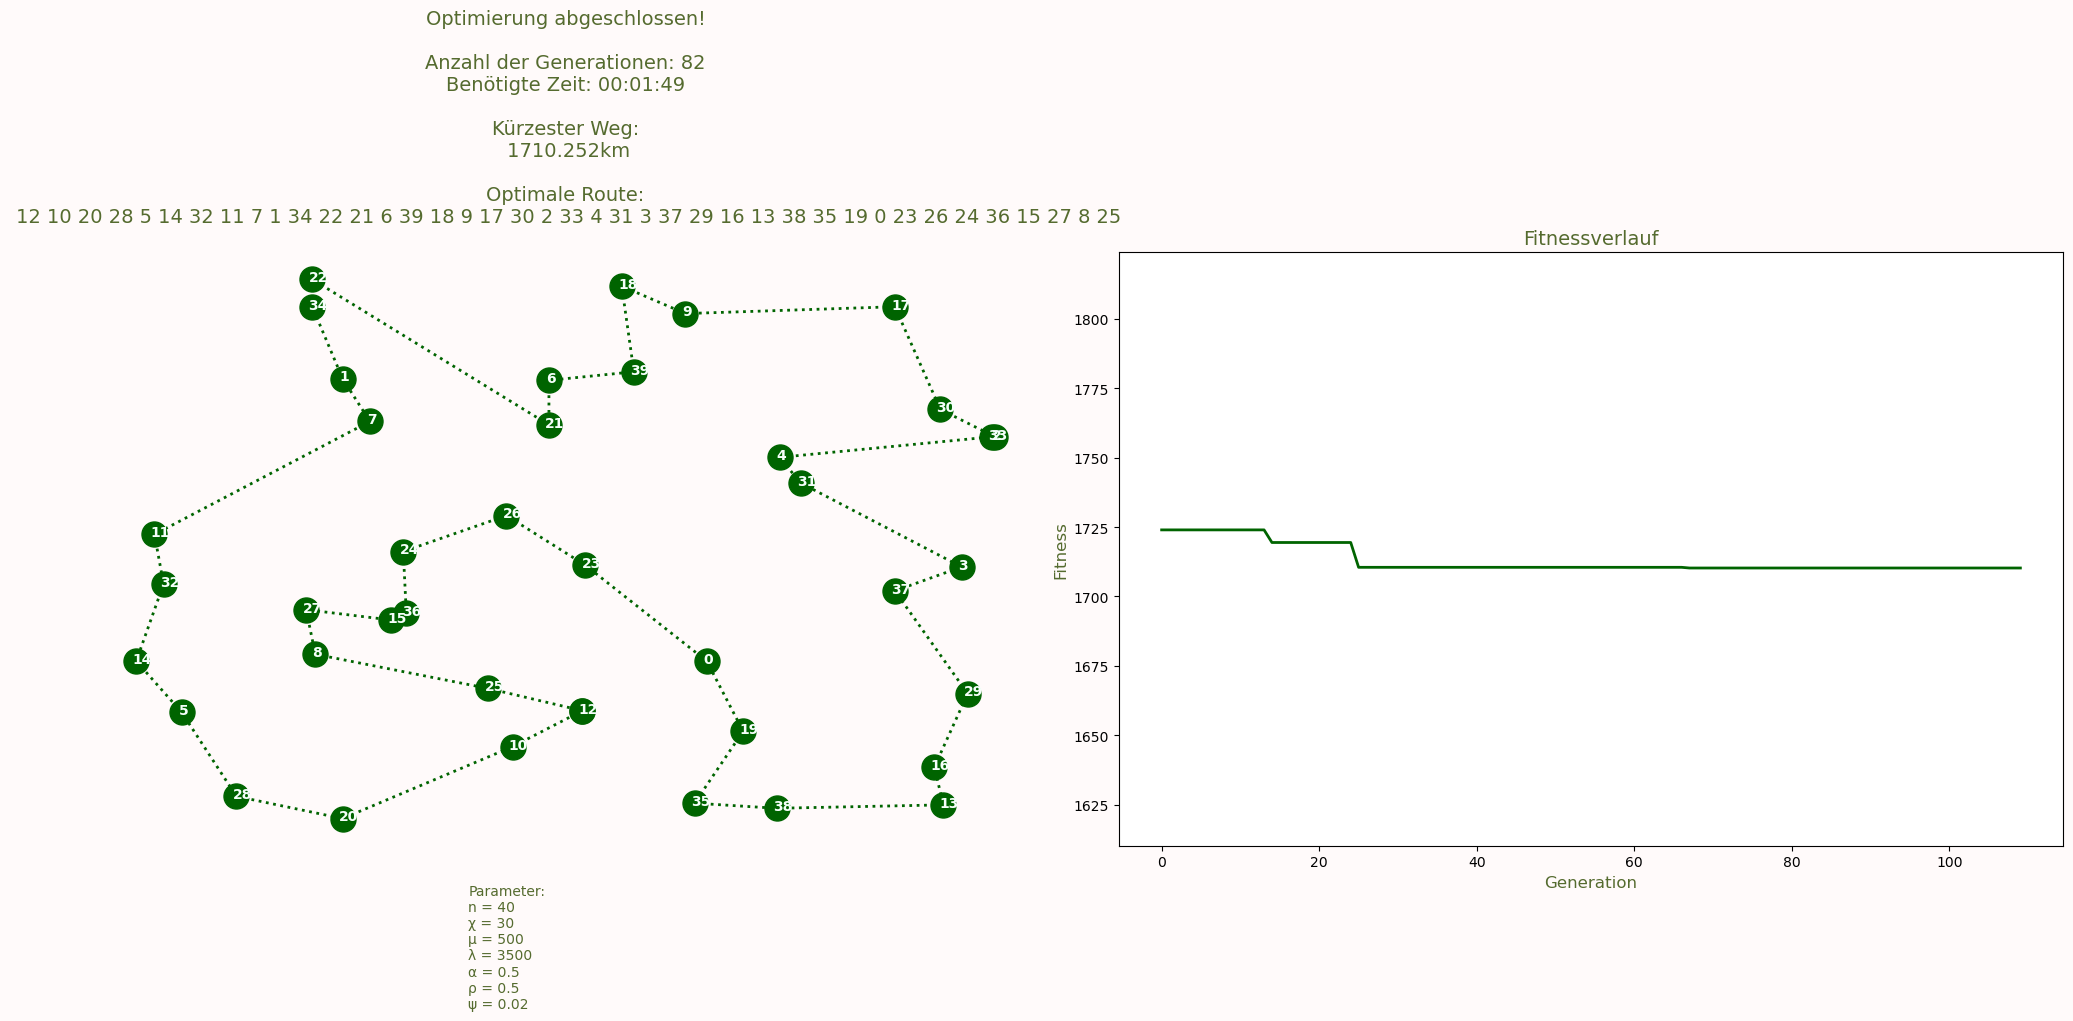

In [11]:
# Evolutionärer Algorithmus

# Importiere der Parameter des initialen TSP Problems
df = pd.read_csv('TSP_Initial_Problem.csv')
Koord = df.values
x = Koord[:, 0]
y = Koord[:, 1]
n = df['n'][0]
m = df['m'][0]

# Bestimmung der Entfernungsmatrix
Entfernungsmatrix = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        Entfernungsmatrix[i, j] = np.linalg.norm(Koord[i] - Koord[j])

# Beliebiges Durchlaufen der Standorte
Folge = np.random.permutation(n)

# Berechnung der zurückgelegten Entfernung
Entf = Entfernungsmatrix[Folge[n-1], Folge[0]]

for i in range(n-1):
    Entf += Entfernungsmatrix[Folge[i], Folge[i+1]]

# Generationszaehler
g = 0

# Counter für die Anzahl der Generationen ohne Verbesserung
no_change_counter = 0

# Selektionsdruck
selectp = ρ.value

# Anzahl der Kinder
n_children = λ.value * μ.value

# Initialisierung der Population
P = np.zeros((μ.value, n), dtype=int)
for i in range(μ.value):
    if np.random.rand() < ψ.value:
        P[i] = GreedySolution()
    else:
        P[i] = np.random.permutation(n)

# Berechnung der Fitnesswerte der Startpopulation
Fitness = np.zeros(μ.value)
for i in range(μ.value):
    Fitness[i] = GetFitness(P[i])

# Speicher für die besten Ablauffolgen
Best_Elter_xx = np.zeros((Σ.value, n+1))
Best_Elter_yy = np.zeros((Σ.value, n+1))
Best_Fitness = np.zeros(Σ.value)

# Initialisierung des Plots
fig = plt.figure()
fig.set_size_inches(plot_size*2, plot_size)
fig.set_tight_layout(True)
fig.patch.set_facecolor('snow')

ax = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
plt.subplots_adjust(wspace=1.5)

Init_Fit = 0

# Startzeitpunkt
start = time.time()

while g < Σ.value:

    # Erzeugung von n_children Nachkommen P_ durch Rekombination aus P(g)
    P_ = np.zeros((n_children, n), dtype=int)
    P__ = np.zeros((n_children, n), dtype=int)
    for i in range(n_children):
        # Auswahl zweier Eltern aus P(g)
        Eltern = np.random.choice(μ.value, 2, replace=False)
        # Rekombination der Eltern
        P_[i] = CrossOver(P[Eltern[0]], P[Eltern[1]])
        # Mutation des Nachkommen
        P__[i] = Mutation(P_[i], α.value)

    # Berechnung der Fitnesswerte der Nachkommen
    Fitness__ = np.zeros(n_children)
    for i in range(n_children):
        Fitness__[i] = GetFitness(P__[i])

    # Sorierung der Nachkommen nach Fitness
    Indizes = np.argsort(Fitness__)
    P__ = P__[Indizes]
    Fitness__ = Fitness__[Indizes]

    # Prüfen, ob sich die beste Lösung verbessert hat
    if CheckChange(Fitness[0], Fitness__[0]):
        no_change_counter += 1
    else:
        no_change_counter = 0

    # Falls sich die beste Lösung seit 10 Generationen nicht verbessert hat
    if no_change_counter == χ.value:
        # Endzeitpunkt
        end = time.time()
        
        g_end = g+1-no_change_counter
        
        if live_plot.value:
        # Ausgabe der Informationen
            ax.set_title('Optimierung abgeschlossen!\n\nAnzahl der Generationen: ' + str(g_end)
                        + '\nBenötigte Zeit: ' + str(time.strftime('%H:%M:%S', time.gmtime(end-start)))  
                        + '\n\nKürzester Weg:\n ' + str(round(Fitness[0],3)) 
                        + 'km\n\nOptimale Route:\n ' + ' '.join(map(str, P[0])) 
                        + '\n', fontsize=14,color='darkolivegreen')
            ax.text(m/2.2, -m/3, 'Parameter:\nn = ' + str(n) + '\nχ = ' + str(χ.value) 
                                        + '\nμ = ' + str(μ.value) + '\nλ = ' + str(n_children) + '\nα = ' + str(α.value) + '\nρ = ' + str(ρ.value) 
                                        + '\nψ = ' + str(ψ.value), fontsize=10, color='darkolivegreen')
        else:
            ax.plot(xb, yb, ':o', color='darkgreen', linewidth=2, markersize=18)
            for i in range(n):
                if i >= 10:
                    ax.text(x[i]-plot_size/8, y[i]-plot_size/9, str(i), color='mintcream', fontsize=10, fontweight='bold')
                else:
                    ax.text(x[i]-plot_size/10, y[i]-plot_size/9, str(i), color='mintcream', fontsize=10, fontweight='bold')
                ax.set_title('Optimierung abgeschlossen!\n\nAnzahl der Generationen: ' + str(g_end)
                                        + '\nBenötigte Zeit: ' + str(time.strftime('%H:%M:%S', time.gmtime(end-start)))  
                                        + '\n\nKürzester Weg:\n ' + str(round(Fitness[0],3)) 
                                        + 'km\n\nOptimale Route:\n ' + ' '.join(map(str, P[0])) 
                                        + '\n', fontsize=14,color='darkolivegreen')
            ax.text(m/2.2, -m/3, 'Parameter:\nn = ' + str(n) + '\nχ = ' + str(χ.value) 
                                        + '\nμ = ' + str(μ.value) + '\nλ = ' + str(n_children) + '\nα = ' + str(α.value) + '\nρ = ' + str(ρ.value) 
                                        + '\nψ = ' + str(ψ.value), fontsize=10, color='darkolivegreen')
            ax.axis('off')
            ax2.plot(Best_Fitness[:g], color='darkgreen', linewidth=2)
            ax2.set_title('Fitnessverlauf', fontsize=14, color='darkolivegreen', fontweight='normal')
            ax2.set_xlabel('Generation', fontsize=12, color='darkolivegreen')
            ax2.set_ylabel('Fitness', fontsize=12, color='darkolivegreen')
            
        Best_Fitness = np.delete(Best_Fitness, np.s_[g+1:])
        break

    # Selektion der μ.value besten Individuen für P(g+1) aus P(g) und P__(g)
    P, Fitness = Selektion(P, P__, Fitness, Fitness__, μ.value, selectp)

    # Speichere die Koodinaten der besten Route in einer Liste
    Best_Elter_xx[g] = np.concatenate((x[P[0]], [x[P[0][0]]]))
    Best_Elter_yy[g] = np.concatenate((y[P[0]], [y[P[0][0]]]))
    
    xb = Best_Elter_xx[g]
    yb = Best_Elter_yy[g]

    if g == 0:
        Init_Fit = Fitness[0]
        
    # Speicherung der besten Fitness
    Best_Fitness[g] = Fitness[0]

    # Live Plot
    if live_plot.value:
        
        # Plot der besten Route
        ax.cla()
        ax.plot(xb, yb, ':o', color='darkgreen', linewidth=2, markersize=18)
        for i in range(n):
            if i >= 10:
                ax.text(x[i]-plot_size/8, y[i]-plot_size/9, str(i), color='mintcream', fontsize=10, fontweight='bold')
            else:
                ax.text(x[i]-plot_size/10, y[i]-plot_size/9, str(i), color='mintcream', fontsize=10, fontweight='bold')             
        ax.set_title('Generation: ' + str(g+1) + ',    Fitness: ' + str(round(Fitness[0],3)) + ',    Keine Veränderung seit: ' 
                    + str(no_change_counter) + ' Generationen', fontsize=14, color='darkolivegreen', fontweight='normal') 
        ax.axis('off')
    
        # Plot des Fitnessverlaufs
        ax2.cla()
        ax2.plot(Best_Fitness[:g], color='darkgreen', linewidth=2)
        ax2.set_title('Fitnessverlauf', fontsize=14, color='darkolivegreen', fontweight='normal')
        ax2.set_xlabel('Generation', fontsize=12, color='darkolivegreen')
        ax2.set_ylabel('Fitness', fontsize=12, color='darkolivegreen')
        ax2.set_ylim([Best_Fitness[g]-100, Init_Fit+100])

        display(fig)

        clear_output(wait = True)
    else:
        print('Generation: ' + str(g+1) + ',    Fitness: ' + str(round(Fitness[0],3)) + ',    Keine Veränderung seit: ' 
                    + str(no_change_counter) + ' Generationen')
        clear_output(wait = True)

    # increment sd depending on the number of generations without improvement
    if no_change_counter >= χ.value/2:
        selectp += 0.05
        if selectp > 1:
            selectp = 1
    else:
        selectp = ρ.value

    g += 1